<h2>Importar as bibliotecas</h2>

In [1]:
import pandas as pd
import numpy as np
import xgboost
import shap
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

<h2>Conjunto de dados</h2>

In [2]:
dataset = pd.read_csv('Traffic_Incidents_Braga_Until_20190228.csv', na_values='NaN')

dataset.head()

,city_name,description,cause_of_incident,from_road,to_road,affected_roads,incident_category_desc,magnitude_of_delay_desc,length_in_meters,delay_in_seconds,incident_date
0,Braga,stationary traffic,NaN,Braga-Circular (A11),Celeirós (IP9) (A11),A11,Jam,Major,583,123,2019-02-28 23:45:00.098000
1,Braga,closed,NaN,Avenida Doutor Francisco Salgado Zenha,Avenida Robert Smith,NaN,Road Closed,Undefined,60,0,2019-02-28 23:45:00.098000
2,Braga,stationary traffic,NaN,Braga-Circular (A11),Celeirós (IP9) (A11),A11,Jam,Major,662,191,2019-02-28 23:25:00.353000
3,Braga,closed,NaN,Avenida Doutor Francisco Salgado Zenha,Avenida Robert Smith,NaN,Road Closed,Undefined,60,0,2019-02-28 23:25:00.353000
4,Braga,slow traffic,NaN,Braga-Circular (A11),Celeirós (IP9) (A11),A11,Jam,Minor,662,26,2019-02-28 23:05:00.154000


<h2>Verificação dos valores em falta</h2>

In [3]:
#dataset.isnull().sum()

<h2>Tratamento dos valores em falta</h2>

In [4]:
dataset[['cause_of_incident','affected_roads']] = dataset[['cause_of_incident','affected_roads']].fillna('None')

<h2>Eliminação de colunas sem valor adicional</h2>

In [5]:
dataset = dataset.drop(['city_name','from_road','to_road','affected_roads','incident_date'], axis = 1)
dataset.head()

,description,cause_of_incident,incident_category_desc,magnitude_of_delay_desc,length_in_meters,delay_in_seconds
0,stationary traffic,None,Jam,Major,583,123
1,closed,None,Road Closed,Undefined,60,0
2,stationary traffic,None,Jam,Major,662,191
3,closed,None,Road Closed,Undefined,60,0
4,slow traffic,None,Jam,Minor,662,26


<h2>Obter os valores</h2>

In [6]:
X = dataset.iloc[:, :]

<h2>Identificar as colunas categóricas</h2>

In [7]:
categorical_feature_mask = X.dtypes==object

categorical_cols = X.columns[categorical_feature_mask].tolist()

<h2>Codificação das variáveis independentes categóricas</h2>

In [8]:
labelEncoder = LabelEncoder()

X[categorical_cols] = X[categorical_cols].apply(lambda col: labelEncoder.fit_transform(col))

oneHotEncoder = OneHotEncoder(categorical_features = categorical_feature_mask, sparse=False )

X_oneHotEncoder = oneHotEncoder.fit_transform(X)

X.head()

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:392: DeprecationWarning: The 'categorical_features' keyword is deprecated in version 0.20 and will be removed in 0.22. You can use the ColumnTransformer instead.
  "use the ColumnTransformer instead.", DeprecationWarning)


,description,cause_of_incident,incident_category_desc,magnitude_of_delay_desc,length_in_meters,delay_in_seconds
0,6,0,1,0,583,123
1,1,0,3,3,60,0
2,6,0,1,0,662,191
3,1,0,3,3,60,0
4,5,0,1,1,662,26


<h2>Feature Scaling</h2>

In [9]:
sc = StandardScaler()
X = sc.fit_transform(X)
X

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


array([[ 1.03454698, -0.02524751, -0.89435272, -1.16973962,  0.62749341,
        -0.00979197],
       [-1.03576071, -0.02524751,  1.09986431,  0.9861592 , -0.75935593,
        -0.75995856],
       [ 1.03454698, -0.02524751, -0.89435272, -1.16973962,  0.83697926,
         0.40493428],
       ...,
       [-0.20763763, -0.02524751, -0.89435272,  0.26752626,  1.33550253,
        -0.17446268],
       [-0.20763763, -0.02524751, -0.89435272, -1.16973962, -0.2820464 ,
        -0.42451821],
       [ 1.03454698, -0.02524751, -0.89435272, -1.16973962, -0.38811519,
         0.44152777]])

<h2>K-Means</h2>
<p>Elbow method</p>

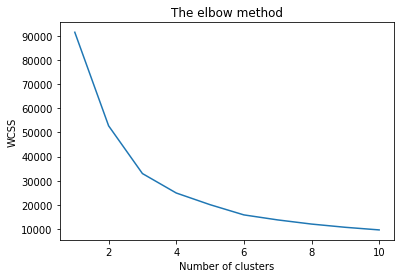

In [18]:
from sklearn.cluster import KMeans
new_X = X[:, [4,5]]
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter= 300, n_init= 10, random_state=0, n_jobs=-1)
    kmeans.fit(new_X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title("The elbow method")
plt.xlabel("Number of clusters")
plt.ylabel("WCSS")
plt.show()

<h2>Aplicação do k-means ao conjunto de dados</h2>

In [19]:
kmeans = KMeans(n_clusters=4, init='k-means++', n_init=10, n_jobs=-1, random_state=0)
y_kmeans = kmeans.fit_predict(new_X)
y_kmeans #classificação dos clusters para cada registo do conjunto de dados

array([3, 0, 3, ..., 2, 0, 3], dtype=int32)

<h2>Visualização dos clusters</h2>

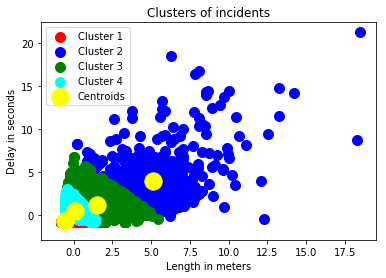

In [20]:
plt.scatter(new_X[y_kmeans == 0, 0], new_X[y_kmeans == 0, 1], s = 100, c = 'red', label='Cluster 1')
plt.scatter(new_X[y_kmeans == 1, 0], new_X[y_kmeans == 1, 1], s = 100, c = 'blue', label='Cluster 2')
plt.scatter(new_X[y_kmeans == 2, 0], new_X[y_kmeans == 2, 1], s = 100, c = 'green', label='Cluster 3')
plt.scatter(new_X[y_kmeans == 3, 0], new_X[y_kmeans == 3, 1], s = 100, c = 'cyan', label='Cluster 4')
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], s = 300, c = 'yellow', label='Centroids')
plt.title('Clusters of incidents')
plt.xlabel('Length in meters')
plt.ylabel('Delay in seconds')
plt.legend()
plt.show()